In [1]:
from iminuit import Minuit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import sympy as sp
import seaborn as sb
from ExternalFunctions import Chi2Regression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [99]:
test = 10*np.array([2.69,2.71,2.56,2.48,2.34,2.79,2.54,2.68,2.69,2.58,2.66,2.70])
errs = [1,1,1,1,1,1,1,1,0.01,1,1,1,]

In [39]:
def weighted_avg(y,x=None,yerr = None,ax = None,label="Data",col = "k"):
    if not x:
        x = range(len(y))
    if not yerr:
        yerr = np.ones(len(y))*np.std(y)
    func = lambda x,a: a + 0*x
    chi = Chi2Regression(func,x,y,yerr)
    mi = Minuit(chi,pedantic = False,print_level=0,a=1)
    mi.migrad()
    a = mi.args[0]
    err = mi.errors[0]
    xx = np.linspace(min(x),max(x),1000)
    
    if not ax:
        fig, ax = plt.subplots()
    ax.errorbar(x,y,yerr=yerr,fmt = col+'.',capsize = 2,label = label)
    ax.plot(xx,func(xx,a),ls='--',c='b',label = "Average: ${:.3}\pm{:.3}$".format(a,err))
    ax.legend()
    
    return mi,ax

In [78]:
def fit_unit_gauss(x,y,yerr,muguess=None,ax=None,col='k',label = "Data"):
    if not muguess:
        muguess = (max(x)-min(x))/2
    func = lambda x,mu,sigma: stats.norm.pdf(x,mu,sigma)
    chi = Chi2Regression(func,x,y,yerr)
    mi = Minuit(chi,pedantic = False,print_level=0,mu = muguess,sigma = 1)
    mi.migrad()
    mu,sigma = mi.args
    
    xx = np.linspace(min(x),max(x),1000)
    if not ax:
        fig, ax = plt.subplots()
    ax.errorbar(x,y,yerr=yerr,fmt = col+'.',capsize = 2,label = label)
    ax.plot(xx,func(xx,*mi.args),ls='--',c='b',label = "Gauss$(\mu: {:.3},\sigma: {:.3})$".format(mu,sigma))
    ax.legend()
    
    return mi,ax

def fit_gauss(x,y,yerr,muguess=None,ax=None,col='k',label = "Data"):
    if not muguess:
        muguess = (max(x)-min(x))/2
    func = lambda x,mu,sigma,a: stats.norm.pdf(x,mu,sigma)*a
    chi = Chi2Regression(func,x,y,yerr)
    mi = Minuit(chi,pedantic = False,print_level=0,mu = muguess,sigma = 1,a=1)
    mi.migrad()
    mu,sigma,a = mi.args
    
    xx = np.linspace(min(x),max(x),1000)
    if not ax:
        fig, ax = plt.subplots()
    ax.errorbar(x,y,yerr=yerr,fmt = col+'.',capsize = 2,label = label)
    ax.plot(xx,func(xx,*mi.args),ls='--',c='b',label = "Gauss$(\mu: {:.3},\sigma: {:.3})$".format(mu,sigma))
    ax.legend()
    
    return mi,ax

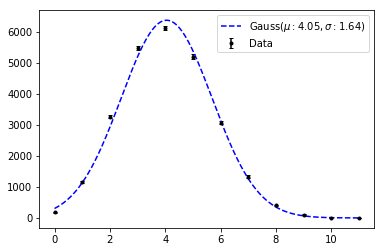

In [74]:
testgauss = [185,1149,3265,5475,6114,5194,3067,1331,403,105,14,4]

t = fit_gauss(range(len(testgauss)),testgauss,np.sqrt(testgauss))

In [143]:
def chi2fit(x,y,yerr,func,guesses,label="Data",ax=None,col='k',text=False):
    chi = Chi2Regression(func,x,y,yerr)
    gstr = ""
    for key in guesses:
        gstr+=str(key)+"="+str(guesses[key])+","
        
    mistr = "Minuit(chi,pedantic = False,print_level=0,"+gstr+")"
    mi = eval(mistr)
    mi.migrad()
    
    xx = np.linspace(min(x),max(x),1000)
    if not ax:
        fig, ax = plt.subplots()
    ax.errorbar(x,y,yerr=yerr,fmt = col+'.',capsize = 2,label = label)
    dstr = "Fit values:\n"
    for i,key in enumerate(guesses):
        dstr+=str(key)+"={:.3}$\pm${:.3} ".format(mi.args[i],mi.errors[i])+"\n"
    dstr+="\n"
    dstr+="$\chi^2$={:.3}\np-value={:.3}".format(mi.fval,stats.chi2.sf(mi.fval,len(y)-len(guesses)))
    ax.plot(xx,func(xx,*mi.args),ls='--',c='b',label = "Fit")
    if(text):
        ax.text(text[0],text[1],dstr,transform=ax.transAxes)
    ax.legend()
    
    return mi,ax
    

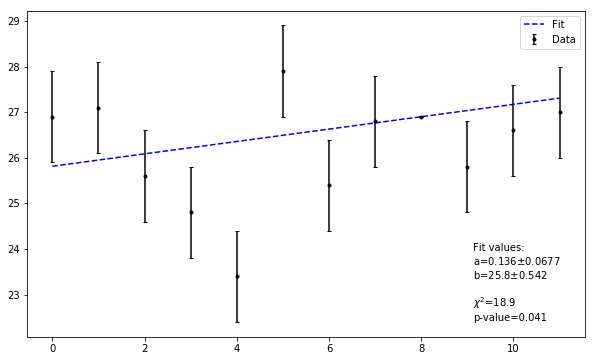

In [181]:
func = lambda x,a,b: a*x+b
x,y = range(len(test)),test
yerrs = errs
guesses = {"a":2,"b":3}
textpos =(0.8,0.05)
fig,ax =plt.subplots(figsize=(10,6))
mi,ax = chi2fit(x,y,yerrs,func,guesses,text=textpos,ax = ax)


In [222]:
def errorpropagate(func,symbols = None,correlation=None):
    if not symbols:
        symbols = func.free_symbols
    inner=0
    cor = 1
    for s in symbols:
        sig = sp.symbols("\\sigma_{"+str(s)+"}")
        inner += sp.diff(func,s)**2*sig**2
        cor *= sp.diff(func,s)*sig
    if(correlation):
        inner+=2*cor*correlation
    return sp.sqrt(inner)

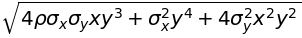

In [223]:
x,y,rho = sp.symbols("x y \\rho")

errorpropagate(x*y**2,correlation=rho)

In [378]:
def from_same_dist(dist1,dist2,labels=None,text = None,ax = None):
    if not ax:
        fig,ax = plt.subplots()
    if not labels:
        labels = ("Distribution 1","Distribution 2")
    h1,b1 = dist1
    h2,b2 = dist2
    
    b1,b2 = ((b1+np.roll(b1,1))/2)[1:],((b2+np.roll(b2,1))/2)[1:]
    ax.errorbar(b1,h1,np.sqrt(h1),fmt=".",capsize=2,label=labels[0])
    ax.errorbar(b2,h2,np.sqrt(h2),fmt=".",capsize=2,label=labels[1])
    
    ks = stats.ks_2samp(h1,h2)
    chi2 = 0
    for t1,t2 in zip(h1,h2):
        if(t2>0):
            chi2 += (t1-t2)**2/t2
    if(text):        
        txt = "KS-statistic:{:.3}\nKS-p-value:{:.3}\n\n$\chi^2$-statistic:{:.3}\n$\chi^2$ p-value{:.3}".format(ks[0],ks[1],chi2,stats.chi2.sf(chi2,2*len(h1)))
        ax.text(text[0],text[1],txt,transform=ax.transAxes)
    plt.legend()
    return ax,(chi2,stats.chi2.sf(chi2,2*len(h1))),ks

(<matplotlib.axes._subplots.AxesSubplot at 0x2641e06e630>,
 (33.60353488148618, 0.7522570969886143),
 Ks_2sampResult(statistic=0.09999999999999998, pvalue=0.999897950688549))

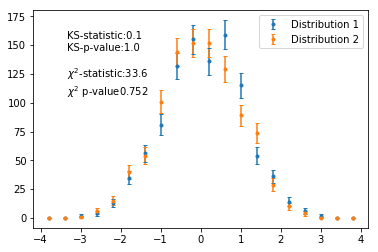

In [390]:
t1,t2 = np.random.normal(size=(2,1000))
d1 = np.histogram(t1,20,range=(-4,4))
d2 = np.histogram(t2,20,range=(-4,4))

from_same_dist(d1,d2,text=(0.1,0.6))

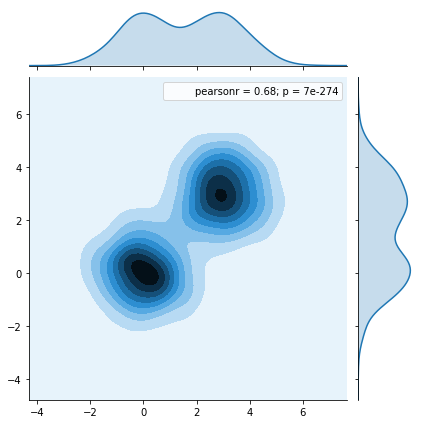

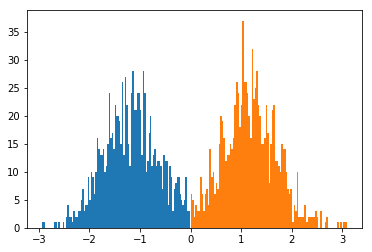

array([[ 1.38412555, -0.67064589],
       [ 1.55164298,  0.90529907],
       [ 2.04737023, -0.18143027],
       ...,
       [-1.11661312, -0.79631588],
       [-1.75572087, -0.6896332 ],
       [-1.54770943,  0.79076505]])

In [419]:
t1,t2,t3,t4 = np.random.normal(size=(4,1000))
t1+=3
t3+=3
d1 = np.concatenate((t1,t2))
d2 = np.concatenate((t3,t4))

def separate_two(d1,d2,separation=None):
    sb.jointplot(d1,d2,kind='kde')
    X = pd.DataFrame([d1,d2])
    X = X.transpose()
    X = StandardScaler().fit_transform(X)
    pca = PCA(n_components=2)
    Xfit = pca.fit_transform(X)
    principalDf = pd.DataFrame(data = Xfit
                 , columns = ['principal component 1', 'principal component 2'])
    
    fig,ax = plt.subplots()
    s = principalDf['principal component 1']
    if separation!=None:
        dat1 = s[s<separation]
        dat2 = s[s>separation]
        ax.hist(dat1,bins=100)
        ax.hist(dat2,bins=100)
    else:
        ax.hist(principalDf['principal component 1'],bins=100)
    plt.show()
    
    if separation!=None:
        return (dat1,dat2),ax,xfit
    return principalDf,ax,Xfit


def do_lda(dat1,dat2):
    X = np.vstack((dat1, dat2))
    N = len(dat1)
    y = np.zeros(2*N) 
    y[:N] = 1
    
    # initialise the LDA method
    sklearn_lda = LDA(n_components=2)

    # fit the data
    sklearn_lda.fit(X, y)

    # transform the data
    X_lda_sklearn = sklearn_lda.transform(X) 

    print(f"LDA coefficients: {sklearn_lda.scalings_}")

dat,ax,xfit = separate_two(d1,d2,0)



In [271]:
h

array([  9,  25,  76, 141, 218, 239, 171,  92,  22,   7], dtype=int64)